Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import random
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

We will write a function that will be used for creating a generic graph of deep networks

In [5]:
#
# Builds the graph using the provided information, 
# the activation function for the hidden layers is assumed to be RELU
# and the last layer is softmax
#
#
def build_graph(image_size, num_labels, batch_size, hidden_layers, beta = 0.0, keep_prob = 1.0, learning_rate = 0.5):
    num_hidden_layers = len(hidden_layers)
    print('Building network with %d hidden layers, beta for L2 used is %.4f, keep_prob for dropout is %1.2f'%(num_hidden_layers, beta, keep_prob))
    weights = []
    biases = []
    graph = tf.Graph()
    with graph.as_default():
        in_dim = image_size * image_size;
        tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_validation_dataset = tf.constant(valid_dataset)        
        tf_test_dataset = tf.constant(test_dataset)        

        W = tf.Variable(tf.truncated_normal([in_dim, hidden_layers[0] if num_hidden_layers > 0 else num_labels]), name = 'W0')
        B = tf.Variable(tf.zeros(hidden_layers[0] if num_hidden_layers > 0 else num_labels), name = 'B0')
        z = tf.matmul(tf_train_dataset, W) + B
        weights.append(W)
        biases.append(B)        
        for i in range(0, num_hidden_layers):
            a_prev = tf.nn.relu(z)
            a_prev_drop = tf.nn.dropout(a_prev, keep_prob = keep_prob)
            next_layer_num_units = hidden_layers[i + 1] if i + 1 < num_hidden_layers else num_labels
            W = tf.Variable(tf.truncated_normal([hidden_layers[i], next_layer_num_units]), name = 'W' + str(i + 1))
            B = tf.Variable(tf.zeros(next_layer_num_units), name = 'B' + str(i + 1))
            z = tf.matmul(a_prev_drop, W) + B
            weights.append(W)
            biases.append(B)            
        
            
        train_prediction = tf.nn.softmax(z)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = z) + \
                              beta * tf.reduce_sum([tf.nn.l2_loss(x) for x in weights]))
        
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        optimizer = tf.train.AdamOptimizer().minimize(loss)
        
        def _run(input_data):
            W = weights[0]
            B = biases[0]
            z = tf.matmul(input_data, W) + B
            for i in range(1, len(weights)):
                a_prev = tf.nn.relu(z)
                W = weights[i]
                B = biases[i]
                z = tf.matmul(a_prev, W) + B
                
            return tf.nn.softmax(z)
        
        test_prediction = _run(tf_test_dataset)
        valid_prediction = _run(tf_validation_dataset)
        
        
        return graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, train_prediction, test_prediction, valid_prediction
                            

Trying Above function to predict on the accuracy of our prediction using 1 hidden layer of 1024 units and no regularization or dropout, this should give results similar to our training in 2_fullyconnected

In [6]:
num_steps = 3001
random.seed(0)
batch_size = 128

graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, \
train_prediction, test_prediction, valid_prediction = build_graph(image_size, num_labels, batch_size, [1024])
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Building network with 1 hidden layers, beta for L2 used is 0.0000, keep_prob for dropout is 1.00
Initialized
Minibatch loss at step 0: 294.955475
Minibatch accuracy: 10.2%
Validation accuracy: 12.5%
Minibatch loss at step 500: 21.200291
Minibatch accuracy: 78.1%
Validation accuracy: 78.6%
Minibatch loss at step 1000: 28.521343
Minibatch accuracy: 76.6%
Validation accuracy: 80.1%
Minibatch loss at step 1500: 11.646664
Minibatch accuracy: 88.3%
Validation accuracy: 81.6%
Minibatch loss at step 2000: 16.437450
Minibatch accuracy: 87.5%
Validation accuracy: 82.0%
Minibatch loss at step 2500: 12.490782
Minibatch accuracy: 83.6%
Validation accuracy: 82.9%
Minibatch loss at step 3000: 17.649899
Minibatch accuracy: 79.7%
Validation accuracy: 83.3%
Test accuracy: 90.0%


With the function for building the graph in place, lets plot the validation set error plotted against various values of regularization. We will start with 0.001 and keep doubling the values till we reach 0.256.

In [7]:
random.seed(0)
betas = [0.0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
num_steps = 3001
max_validation_accuracy = 0.0
all_validation_accuracies = []
best_beta = 0.0
test_accuracy = 0.0
final_test_variable = None
for beta in betas:
    graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, \
    train_prediction, test_prediction, valid_prediction = build_graph(image_size, num_labels, batch_size, [1024], beta)
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
      validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      all_validation_accuracies.append(validation_accuracy)
      if validation_accuracy > max_validation_accuracy:
        max_validation_accuracy = validation_accuracy
        best_beta = beta
        test_accuracy = accuracy(test_prediction.eval(), test_labels)

            
print("Best validation accuracy %.1f%% found with beta %f, Test accuracy is : %.1f%%" % \
            ( max_validation_accuracy, best_beta, test_accuracy))
    
  

Building network with 1 hidden layers, beta for L2 used is 0.0000, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0010, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0020, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0040, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0080, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0160, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0320, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.0640, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.1280, keep_prob for dropout is 1.00
Building network with 1 hidden layers, beta for L2 used is 0.2560, keep_prob for dropout is 1.00
Best validation accuracy 83.1%

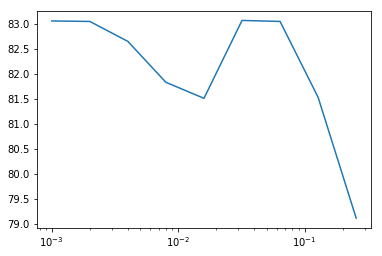

In [8]:
plt.semilogx(betas, all_validation_accuracies)
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
num_steps = 3001
random.seed(0)

graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, \
train_prediction, test_prediction, valid_prediction = build_graph(image_size, num_labels, batch_size, [1024])
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    offset = 0
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Building network with 1 hidden layers, beta for L2 used is 0.0000, keep_prob for dropout is 1.00
Initialized
Minibatch loss at step 0: 366.194824
Minibatch accuracy: 7.8%
Validation accuracy: 8.0%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 45.9%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 45.9%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 45.9%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 45.9%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 45.9%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 45.9%
Test accuracy: 50.6%


As we can see above, the minibatch accuracy soon became 100, that is the the network soon learnt the 128 samples of the test set, it however ganeralized badly. This is evident from the validation and test set accuracy

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

First case, same overfitting case as above, but introduce dropouts with probablity 0.5

In [10]:
num_steps = 3001
random.seed(0)

graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, \
train_prediction, test_prediction, valid_prediction = build_graph(image_size, num_labels, batch_size, [1024], keep_prob = 0.5)
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    offset = 0
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Building network with 1 hidden layers, beta for L2 used is 0.0000, keep_prob for dropout is 0.50
Initialized
Minibatch loss at step 0: 509.585907
Minibatch accuracy: 8.6%
Validation accuracy: 11.1%
Minibatch loss at step 500: 1.558127
Minibatch accuracy: 97.7%
Validation accuracy: 66.1%
Minibatch loss at step 1000: 0.007435
Minibatch accuracy: 99.2%
Validation accuracy: 66.6%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.1%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.0%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 67.7%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 68.0%
Test accuracy: 74.7%


As we see above, intrducing dropouts made the network more robust to overfitting. Even though we had the training accuracy of 100, we see fair improvement in the validation and test accuracy than with no dropouts, next we will train the entire network with a keep probablity of 0.5

In [11]:
num_steps = 4001
random.seed(0)
graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, \
train_prediction, test_prediction, valid_prediction = build_graph(image_size, num_labels, batch_size, [1024], keep_prob = 0.6)
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Building network with 1 hidden layers, beta for L2 used is 0.0000, keep_prob for dropout is 0.60
Initialized
Minibatch loss at step 0: 482.478058
Minibatch accuracy: 7.8%
Validation accuracy: 6.0%
Minibatch loss at step 500: 40.777481
Minibatch accuracy: 80.5%
Validation accuracy: 81.0%
Minibatch loss at step 1000: 54.298447
Minibatch accuracy: 74.2%
Validation accuracy: 82.7%
Minibatch loss at step 1500: 31.203287
Minibatch accuracy: 81.2%
Validation accuracy: 83.6%
Minibatch loss at step 2000: 24.771816
Minibatch accuracy: 80.5%
Validation accuracy: 83.9%
Minibatch loss at step 2500: 30.826645
Minibatch accuracy: 77.3%
Validation accuracy: 83.9%
Minibatch loss at step 3000: 16.039171
Minibatch accuracy: 75.8%
Validation accuracy: 84.0%
Minibatch loss at step 3500: 29.008530
Minibatch accuracy: 84.4%
Validation accuracy: 84.1%
Minibatch loss at step 4000: 16.040627
Minibatch accuracy: 81.2%
Validation accuracy: 84.2%
Test accuracy: 91.1%


We increased the number of steps and introduced dropout with a keep_prob of 0.6 and we see a fair bit of improvement, this seems like even a better regularization than using L2 regularization (for the case we have in hand on the data tested)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [17]:
num_steps = 30001
batch_size = 128
random.seed(0)
graph, tf_train_dataset, tf_train_labels, weights, biases, loss, optimizer, \
train_prediction, test_prediction, valid_prediction = build_graph(image_size, num_labels, batch_size, [1024, 16], \
                                                                  beta = 0.001)
#print(weights)
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 3000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Building network with 2 hidden layers, beta for L2 used is 0.0010, keep_prob for dropout is 1.00
Initialized
Minibatch loss at step 0: 1290.310791
Minibatch accuracy: 9.4%
Validation accuracy: 9.8%
Minibatch loss at step 3000: 176.297638
Minibatch accuracy: 25.0%
Validation accuracy: 22.4%
Minibatch loss at step 6000: 27.997793
Minibatch accuracy: 28.1%
Validation accuracy: 29.2%
Minibatch loss at step 9000: 3.601903
Minibatch accuracy: 68.0%
Validation accuracy: 73.7%
Minibatch loss at step 12000: 0.898956
Minibatch accuracy: 85.2%
Validation accuracy: 85.1%
Minibatch loss at step 15000: 0.561044
Minibatch accuracy: 89.8%
Validation accuracy: 87.0%
Minibatch loss at step 18000: 0.434034
Minibatch accuracy: 90.6%
Validation accuracy: 87.2%
Minibatch loss at step 21000: 0.440380
Minibatch accuracy: 88.3%
Validation accuracy: 87.6%
Minibatch loss at step 24000: 0.400958
Minibatch accuracy: 89.1%
Validation accuracy: 87.9%
Minibatch loss at step 27000: 0.481082
Minibatch accuracy: 89.1%
V

The accuracy of 94.2% seems reasonable enough to start with. We can however improve the performance further, making the network deeper isnt really an option for me personally due to the hardware constraints. Further more, no data manipulation was done before splitting the data in train, validation and test set